# Example of using the Borehole3D class

## Imports

In [1]:
from striplog import Component, Decor, Legend, Lexicon, Striplog
from core.visual import Borehole3D, striplog_legend_to_omf_legend 
from utils.lexicon.lexicon_memoris import lexicon_memoris, lithology_memoris, pollutants_memoris, CONTAMINATION_LEVELS_MEMORIS
from utils.orm import boreholes_from_dataframe
from utils.io import dataframe_viewer
from core.project import Project
from core.orm import BoreholeOrm, PositionOrm, Base 
import random
from os import remove
import re
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from definitions import ROOT_DIR

## Reading of CSV files in a dir

In [2]:
#df = pd.read_csv('test_data_boreholes.csv', sep=',') # use english lexicon
df = pd.read_csv('test_litho_fr.csv', sep=',') # use french lexicon

In [3]:
all_pollutants = pollutants_memoris.pollutant

## Data Checking

In [4]:
#df[['Pollutant', 'Concentration']] = ''
df.drop(columns=['Pollutant', 'Concentration', 'Unit'], inplace=True)
#df['Concentration'] = df['Concentration'].apply(lambda x: np.random.randint(0,100))
#df['Unit'] = 'mg/l'

In [5]:
pol_lev = ['VR','VS','VI', 'Inconnu']
df[all_pollutants[0:2]] = ''
df[all_pollutants[0]] = df[all_pollutants[0]].apply(lambda x: random.sample(pol_lev, 1)[0])
df[all_pollutants[1]] = df[all_pollutants[1]].apply(lambda x: random.sample(pol_lev, 1)[0])

In [6]:
df['Lithology'] = df['Lithology'].replace({'Grès':'Marne', 'Calcaire':'Dolomie'})

In [7]:
df.loc[35.5, :] = ['BH007',152794.0, 121111.0, 60.0, 0.57, 45, 'Calcaire', 'Bleu', 4, 41, 45, 'VS', 'VR']
df.loc[25.5, :] = ['BH005',152473.0, 121460.0, 72.0, 0.61, 32, 'Schiste', 'gris', 3, 29, 32, 'VI', 'VR']
df.loc[25.6, :] = ['BH005',152473.0, 121460.0, 68.0, 0.61, 36, 'Calcaire', 'Bleu', 4, 32, 36, 'Inconnu', 'VR']

df.drop(index=4, inplace=True)
df.drop(columns='Colour', inplace=True)
df = df.sort_index().reset_index(drop=True)

In [8]:
pollutants = [p for p in all_pollutants if p in df.columns]

In [9]:
dataframe_viewer(df)

Rows : 997, columns : 12


interactive(children=(IntSlider(value=10, description='rows', max=997, min=10, readout=False), IntSlider(value…

## Create Boreholes from dataframes or files

In [10]:
boreholes, components, link_intv_comp = boreholes_from_dataframe(df[:50], verbose=False,
                                                attributes=['Lithology']+pollutants, 
                                                symbols={'lithology':{'lexicon':lexicon_memoris}}, 
                                                diameter='Diameter', thickness='Thickness')


Dataframe processing...

|__ID:'BH001'
components: [Component({'lithology': 'sable'}), Component({'arsenic': 'vs'}), Component({'cadmium': 'vs'})]
components: [Component({'lithology': 'argile'}), Component({'arsenic': 'inconnu'}), Component({'cadmium': 'inconnu'})]
components: [Component({'lithology': 'marne'}), Component({'arsenic': 'vi'}), Component({'cadmium': 'inconnu'})]
components: [Component({'lithology': 'charbon'}), Component({'arsenic': 'vr'}), Component({'cadmium': 'inconnu'})]
Summary : [Striplog(4 Intervals, start=0.0, stop=28.0)]

|__ID:'BH002'
components: [Component({'lithology': 'sable'}), Component({'arsenic': 'inconnu'}), Component({'cadmium': 'vs'})]
components: [Component({'lithology': 'argile'}), Component({'arsenic': 'vr'}), Component({'cadmium': 'inconnu'})]
components: [Component({'lithology': 'marne'}), Component({'arsenic': 'vi'}), Component({'cadmium': 'vs'})]
components: [Component({'lithology': 'charbon'}), Component({'arsenic': 'vs'}), Component({'cadmium

/home/yanathan/Projects/GSDMA/utils/orm.py:121: SAWarning: relationship 'ComponentOrm.intervals' will copy column Components.id to column Linkintervalcomponent.comp_id, which conflicts with relationship(s): 'IntervalOrm.components' (copies Components.id to Linkintervalcomponent.comp_id). If this is not the intention, consider if these relationships should be linked with back_populates, or if viewonly=True should be applied to one or more if they are read-only. For the less common case that foreign key constraints are partially overlapping, the orm.foreign() annotation can be used to isolate the columns that should be written towards.   To silence this warning, add the parameter 'overlaps="components"' to the 'ComponentOrm.intervals' relationship.
  boreholes_orm.append(BoreholeOrm(id=bh_name))
/home/yanathan/Projects/GSDMA/utils/orm.py:121: SAWarning: relationship 'ComponentOrm.intervals' will copy column Intervals.id to column Linkintervalcomponent.intv_id, which conflicts with relati

In [11]:
boreholes

[<core.orm.BoreholeOrm>(Name=BH001, Length=28.0, Diameter=0.43, Intervals=4),
 <core.orm.BoreholeOrm>(Name=BH002, Length=37.0, Diameter=0.6, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH003, Length=18.0, Diameter=0.41, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH004, Length=26.0, Diameter=0.61, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH005, Length=36.0, Diameter=0.61, Intervals=7),
 <core.orm.BoreholeOrm>(Name=BH006, Length=26.0, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH007, Length=45.0, Diameter=0.57, Intervals=6),
 <core.orm.BoreholeOrm>(Name=BH008, Length=35.0, Diameter=0.39, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH009, Length=40.0, Diameter=0.5, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH10, Length=11.0, Diameter=0.31, Intervals=3)]

In [12]:
components

{0: Component({'lithology': 'sable'}),
 1: Component({'arsenic': 'vs'}),
 2: Component({'cadmium': 'vs'}),
 3: Component({'lithology': 'argile'}),
 4: Component({'arsenic': 'inconnu'}),
 5: Component({'cadmium': 'inconnu'}),
 6: Component({'lithology': 'marne'}),
 7: Component({'arsenic': 'vi'}),
 8: Component({'lithology': 'charbon'}),
 9: Component({'arsenic': 'vr'}),
 10: Component({'cadmium': 'vi'}),
 11: Component({'lithology': 'dolomie'}),
 12: Component({'cadmium': 'vr'}),
 13: Component({'lithology': 'schiste'}),
 14: Component({'lithology': 'calcaire'})}

In [13]:
link_intv_comp

{(0, 0): {'extra_data': ''},
 (0, 1): {'extra_data': ''},
 (0, 2): {'extra_data': ''},
 (1, 3): {'extra_data': ''},
 (1, 4): {'extra_data': ''},
 (1, 5): {'extra_data': ''},
 (2, 6): {'extra_data': ''},
 (2, 7): {'extra_data': ''},
 (2, 5): {'extra_data': ''},
 (3, 8): {'extra_data': ''},
 (3, 9): {'extra_data': ''},
 (3, 5): {'extra_data': ''},
 (4, 0): {'extra_data': ''},
 (4, 4): {'extra_data': ''},
 (4, 2): {'extra_data': ''},
 (5, 3): {'extra_data': ''},
 (5, 9): {'extra_data': ''},
 (5, 5): {'extra_data': ''},
 (6, 6): {'extra_data': ''},
 (6, 7): {'extra_data': ''},
 (6, 2): {'extra_data': ''},
 (7, 8): {'extra_data': ''},
 (7, 1): {'extra_data': ''},
 (7, 10): {'extra_data': ''},
 (8, 11): {'extra_data': ''},
 (8, 1): {'extra_data': ''},
 (8, 12): {'extra_data': ''},
 (9, 0): {'extra_data': ''},
 (9, 1): {'extra_data': ''},
 (9, 12): {'extra_data': ''},
 (10, 3): {'extra_data': ''},
 (10, 1): {'extra_data': ''},
 (10, 12): {'extra_data': ''},
 (11, 6): {'extra_data': ''},
 (11,

In [14]:
link_intv_comp[(0, 0)]['extra_data'] = "{'porosite':1, 'densite':1.8}"

In [15]:
len(boreholes), len(components)

(10, 15)

## Create a project and save data in a database

In [16]:
remove('tmp_files/tfe_orm_db.db')

In [17]:
engine = create_engine('sqlite:///tmp_files/tfe_orm_db.db', echo=True)

In [18]:
Base.metadata.create_all(engine)

2021-08-03 15:07:00,047 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-08-03 15:07:00,048 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Boreholes")
2021-08-03 15:07:00,048 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-08-03 15:07:00,050 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Boreholes")
2021-08-03 15:07:00,050 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-08-03 15:07:00,051 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Intervals")
2021-08-03 15:07:00,052 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-08-03 15:07:00,053 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Intervals")
2021-08-03 15:07:00,053 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-08-03 15:07:00,054 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Components")
2021-08-03 15:07:00,055 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-08-03 15:07:00,055 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Components")
2021-08-03 15:07:00,056 INFO sqlalchemy.engine.Engin

In [19]:
Session = sessionmaker(bind=engine)
session = Session()

## Define project legend(s) and default attribute for representation

In [20]:
leg_dict = {**{'lithology':{'legend':lithology_memoris}},**{k:{'legend':None} for k in pollutants}}

In [21]:
p = Project(session, lexicon=lexicon_memoris, repr_attribute='lithology', legend_dict=leg_dict)

2021-08-03 15:07:00,117 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-08-03 15:07:00,120 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-08-03 15:07:00,120 INFO sqlalchemy.engine.Engine [generated in 0.00086s] ()


In [22]:
p.legend_dict.keys()

dict_keys(['lithology', 'arsenic', 'cadmium'])

In [23]:
p.add_components(components)

2021-08-03 15:07:00,135 INFO sqlalchemy.engine.Engine INSERT INTO "Components" (id, description) VALUES (?, ?)
2021-08-03 15:07:00,136 INFO sqlalchemy.engine.Engine [generated in 0.00150s] ((0, 'Sable'), (1, 'Vs'), (2, 'Vs'), (3, 'Argile'), (4, 'Inconnu'), (5, 'Inconnu'), (6, 'Marne'), (7, 'Vi')  ... displaying 10 of 15 total bound parameter sets ...  (13, 'Schiste'), (14, 'Calcaire'))
2021-08-03 15:07:00,138 INFO sqlalchemy.engine.Engine COMMIT
2021-08-03 15:07:00,141 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-08-03 15:07:00,142 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-08-03 15:07:00,142 INFO sqlalchemy.engine.Engine [cached since 0.0225s ago] ()


In [24]:
p.__components_dict__

{0: Component({'lithology': 'sable'}),
 1: Component({'arsenic': 'vs'}),
 2: Component({'cadmium': 'vs'}),
 3: Component({'lithology': 'argile'}),
 4: Component({'arsenic': 'inconnu'}),
 5: Component({'cadmium': 'inconnu'}),
 6: Component({'lithology': 'marne'}),
 7: Component({'arsenic': 'vi'}),
 8: Component({'lithology': 'charbon'}),
 9: Component({'arsenic': 'vr'}),
 10: Component({'cadmium': 'vi'}),
 11: Component({'lithology': 'dolomie'}),
 12: Component({'cadmium': 'vr'}),
 13: Component({'lithology': 'schiste'}),
 14: Component({'lithology': 'calcaire'})}

Add boreholes into the project

In [25]:
for bh in boreholes:
    p.add_borehole(bh)

2021-08-03 15:07:00,156 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-08-03 15:07:00,158 INFO sqlalchemy.engine.Engine [generated in 0.00124s] ('BH001', 28.0, 0.43)
2021-08-03 15:07:00,160 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-08-03 15:07:00,161 INFO sqlalchemy.engine.Engine [generated in 0.00079s] ((0, 101.0, 101.0, 101.0, 152600.0, 121039.0), (1, 97.0, 97.0, 97.0, 152600.0, 121039.0), (2, 97.0, 97.0, 97.0, 152600.0, 121039.0), (3, 93.0, 93.0, 93.0, 152600.0, 121039.0), (4, 93.0, 93.0, 93.0, 152600.0, 121039.0), (5, 81.0, 81.0, 81.0, 152600.0, 121039.0), (6, 81.0, 81.0, 81.0, 152600.0, 121039.0), (7, 73.0, 73.0, 73.0, 152600.0, 121039.0))
2021-08-03 15:07:00,164 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id, data_id) VALUES (?, ?, ?, ?, ?, ?, ?)
2021-08-03 15:07:00,165 INFO sqlalchemy.e

2021-08-03 15:07:00,241 INFO sqlalchemy.engine.Engine [cached since 0.06472s ago] ('BH002',)
2021-08-03 15:07:00,242 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-08-03 15:07:00,243 INFO sqlalchemy.engine.Engine [cached since 0.05965s ago] (8,)
2021-08-03 15:07:00,245 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-08-03 15:07:00,246 INFO sqlalchemy.engine.Engine [cached since 0.05872s ago] (9,)
2021-08-03 15:07:00,247 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Posit

2021-08-03 15:07:00,306 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-08-03 15:07:00,306 INFO sqlalchemy.engine.Engine [cached since 0.1197s ago] (21,)
2021-08-03 15:07:00,308 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-08-03 15:07:00,309 INFO sqlalchemy.engine.Engine [cached since 0.1259s ago] (22,)
2021-08-03 15:07:00,311 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

2021-08-03 15:07:00,369 INFO sqlalchemy.engine.Engine [cached since 0.1854s ago] (34,)
2021-08-03 15:07:00,370 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-08-03 15:07:00,371 INFO sqlalchemy.engine.Engine [cached since 0.1839s ago] (35,)
2021-08-03 15:07:00,372 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-08-03 15:07:00,373 INFO sqlalchemy.engine.Engine [cached since 0.1897s ago] (36,)
2021-08-03 15:07:00,375 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-08-03 15:07:00,435 INFO sqlalchemy.engine.Engine [cached since 0.2478s ago] (47,)
2021-08-03 15:07:00,436 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-08-03 15:07:00,437 INFO sqlalchemy.engine.Engine [cached since 0.2533s ago] (48,)
2021-08-03 15:07:00,438 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-08-03 15:07:00,439 INFO sqlalchemy.engine.Engine [cached since 0.2521s ago] (49,)
2021-08-03 15:07:00,441 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-08-03 15:07:00,495 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-08-03 15:07:00,496 INFO sqlalchemy.engine.Engine [cached since 0.309s ago] (61,)
Borehole geometry created successfully !
2021-08-03 15:07:00,512 INFO sqlalchemy.engine.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-08-03 15:07:00,513 INFO sqlalchemy.engine.Engine [cached since 0.2922s ago] (100.0, 'BH006')
2021-08-03 15:07:00,514 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-08-03 15:07:00,514 INFO sqlalchemy.engine.Engine [cached since 0.3577s ago] ('BH007', 45.0, 0.57)
2021-08-03 15:07:00,515 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (

2021-08-03 15:07:00,559 INFO sqlalchemy.engine.Engine [cached since 0.3723s ago] (73,)
Borehole geometry created successfully !
2021-08-03 15:07:00,578 INFO sqlalchemy.engine.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-08-03 15:07:00,579 INFO sqlalchemy.engine.Engine [cached since 0.3582s ago] (97.0, 'BH007')
2021-08-03 15:07:00,580 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-08-03 15:07:00,581 INFO sqlalchemy.engine.Engine [cached since 0.4241s ago] ('BH008', 35.0, 0.39)
2021-08-03 15:07:00,582 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-08-03 15:07:00,583 INFO sqlalchemy.engine.Engine [cached since 0.4229s ago] ((74, 101.0, 101.0, 101.0, 152150.0, 121579.0), (75, 98.0, 98.0, 98.0, 152150.0, 121579.0), (76, 98.0, 98.0, 98.0, 152150.0, 121579.0), (77, 97.0, 97.0, 97.0, 152150.0, 121579.0), (78, 97.0, 97.0, 97.0, 152150.0, 121579.0), (

2021-08-03 15:07:00,643 INFO sqlalchemy.engine.Engine [cached since 0.4796s ago] ((42, 'BH009', 0, '{"lithology": "sable"}, {"arsenic": "inconnu"}, {"cadmium": "vr"}', 84, 85, None), (43, 'BH009', 1, '{"lithology": "argile"}, {"arsenic": "vi"}, {"cadmium": "vs"}', 86, 87, None), (44, 'BH009', 2, '{"lithology": "marne"}, {"arsenic": "vi"}, {"cadmium": "vs"}', 88, 89, None), (45, 'BH009', 3, '{"lithology": "charbon"}, {"arsenic": "inconnu"}, {"cadmium": "vr"}', 90, 91, None), (46, 'BH009', 4, '{"lithology": "dolomie"}, {"arsenic": "vi"}, {"cadmium": "vi"}', 92, 93, None))
2021-08-03 15:07:00,645 INFO sqlalchemy.engine.Engine COMMIT
2021-08-03 15:07:00,648 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-08-03 15:07:00,649 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-08-03 15:07:00,649 INFO sqlalchemy.engine.Engine [cached since 0.5299s ago] ()
2021-08

2021-08-03 15:07:00,713 INFO sqlalchemy.engine.Engine [cached since 0.53s ago] (94,)
2021-08-03 15:07:00,715 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-08-03 15:07:00,716 INFO sqlalchemy.engine.Engine [cached since 0.5294s ago] (95,)
2021-08-03 15:07:00,717 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-08-03 15:07:00,718 INFO sqlalchemy.engine.Engine [cached since 0.5347s ago] (96,)
2021-08-03 15:07:00,719 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id"

In [26]:
a=1
p.boreholes_3d[a].name, p.boreholes_3d[a].components

('BH002',
 {0: [Component({'lithology': 'sable'}),
   Component({'arsenic': 'inconnu'}),
   Component({'cadmium': 'vs'})],
  1: [Component({'lithology': 'argile'}),
   Component({'arsenic': 'vr'}),
   Component({'cadmium': 'inconnu'})],
  2: [Component({'lithology': 'marne'}),
   Component({'arsenic': 'vi'}),
   Component({'cadmium': 'vs'})],
  3: [Component({'lithology': 'charbon'}),
   Component({'arsenic': 'vs'}),
   Component({'cadmium': 'vi'})],
  4: [Component({'lithology': 'dolomie'}),
   Component({'arsenic': 'vs'}),
   Component({'cadmium': 'vr'})]})

In [27]:
p.boreholes_orm

2021-08-03 15:07:00,749 INFO sqlalchemy.engine.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-08-03 15:07:00,751 INFO sqlalchemy.engine.Engine [cached since 0.5302s ago] (95.0, 'BH10')
2021-08-03 15:07:00,752 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-08-03 15:07:00,753 INFO sqlalchemy.engine.Engine [cached since 0.5773s ago] ('BH001',)
2021-08-03 15:07:00,755 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_

[<core.orm.BoreholeOrm>(Name=BH001, Length=97.0, Diameter=0.43, Intervals=4),
 <core.orm.BoreholeOrm>(Name=BH002, Length=98.0, Diameter=0.6, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH003, Length=100.0, Diameter=0.41, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH004, Length=96.0, Diameter=0.61, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH005, Length=97.0, Diameter=0.61, Intervals=7),
 <core.orm.BoreholeOrm>(Name=BH006, Length=100.0, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH007, Length=97.0, Diameter=0.57, Intervals=6),
 <core.orm.BoreholeOrm>(Name=BH008, Length=98.0, Diameter=0.39, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH009, Length=94.0, Diameter=0.5, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH10, Length=95.0, Diameter=0.31, Intervals=3)]

In [28]:
p.add_link_components_intervals(link_intv_comp)

2021-08-03 15:07:00,793 INFO sqlalchemy.engine.Engine INSERT INTO "Linkintervalcomponent" (intv_id, comp_id, extra_data) VALUES (?, ?, ?)
2021-08-03 15:07:00,794 INFO sqlalchemy.engine.Engine [generated in 0.00183s] ((0, 0, "{'porosite':1, 'densite':1.8}"), (0, 1, ''), (0, 2, ''), (1, 3, ''), (1, 4, ''), (1, 5, ''), (2, 6, ''), (2, 7, '')  ... displaying 10 of 150 total bound parameter sets ...  (49, 4, ''), (49, 5, ''))
2021-08-03 15:07:00,800 INFO sqlalchemy.engine.Engine COMMIT
2021-08-03 15:07:00,804 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-08-03 15:07:00,804 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-08-03 15:07:00,805 INFO sqlalchemy.engine.Engine [cached since 0.6854s ago] ()


In [29]:
p.commit()
print('Boreholes in the project : ', len(p.boreholes_orm))

2021-08-03 15:07:00,811 INFO sqlalchemy.engine.Engine COMMIT
Boreholes in the project :  10


In [30]:
p.boreholes_orm[2].intervals

2021-08-03 15:07:00,818 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-08-03 15:07:00,820 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-08-03 15:07:00,820 INFO sqlalchemy.engine.Engine [generated in 0.00085s] ('BH003',)
2021-08-03 15:07:00,822 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-08-03 15:07:00,823 INFO sqlalchemy.engine.Engine [cached since 0.6466s ago] ('BH003',)
2021-08-03 15:07:00,825 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_

{9: <core.orm.IntervalOrm>(Id=9, Borehole=BH003, top=<core.orm.PositionOrm object at 0x7f13870d8940>Description={"lithology": "sable"}, {"arsenic": "vs"}, {"cadmium": "vr"}, Components=[<core.orm.ComponentOrm>(Id=0, Description=Sable), <core.orm.ComponentOrm>(Id=1, Description=Vs), <core.orm.ComponentOrm>(Id=12, Description=Vr)]),
 10: <core.orm.IntervalOrm>(Id=10, Borehole=BH003, top=<core.orm.PositionOrm object at 0x7f13872c1820>Description={"lithology": "argile"}, {"arsenic": "vs"}, {"cadmium": "vr"}, Components=[<core.orm.ComponentOrm>(Id=1, Description=Vs), <core.orm.ComponentOrm>(Id=3, Description=Argile), <core.orm.ComponentOrm>(Id=12, Description=Vr)]),
 11: <core.orm.IntervalOrm>(Id=11, Borehole=BH003, top=<core.orm.PositionOrm object at 0x7f13870b5a90>Description={"lithology": "marne"}, {"arsenic": "vs"}, {"cadmium": "vs"}, Components=[<core.orm.ComponentOrm>(Id=1, Description=Vs), <core.orm.ComponentOrm>(Id=2, Description=Vs), <core.orm.ComponentOrm>(Id=6, Description=Marne)

In [31]:
p.refresh(verbose=False)

2021-08-03 15:07:00,850 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-08-03 15:07:00,851 INFO sqlalchemy.engine.Engine [cached since 0.7319s ago] ()


In [32]:
eval(Component({'lithology':'sable'}).json())

{'lithology': 'sable'}

# 2D/3D Display

### 2D Plot

In [33]:
p.plot2d()

### 3D plot

In [34]:
attributes = list(p.legend_dict.keys())
attributes

['lithology', 'arsenic', 'cadmium']

In [35]:
p.update_legend_cmap(update_all_attrib=True)

({'lithology': {'legend': Legend(Decor({'_colour': '#ffcb23', 'width': 3, 'hatch': "'..'", 'component': Component({'lithology': 'sable'})})
   Decor({'_colour': '#d5e6cc', 'width': 3, 'hatch': "'---'", 'component': Component({'lithology': 'argile'})})
   Decor({'_colour': '#7ba1a8', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'marne'})})
   Decor({'_colour': '#000000', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'charbon'})})
   Decor({'_colour': '#fdaffe', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'dolomie'})})
   Decor({'_colour': '#bbffdd', 'width': 3, 'hatch': "'--'", 'component': Component({'lithology': 'schiste'})})
   Decor({'_colour': '#149eff', 'width': 3, 'hatch': "'='", 'component': Component({'lithology': 'calcaire'})})),
   'cmap': <matplotlib.colors.ListedColormap at 0x7f138702ca90>,
   'values': ['sable',
    'argile',
    'marne',
    'charbon',
    'dolomie',
    'schiste',
    'calcaire']},
  'arsenic': {'l

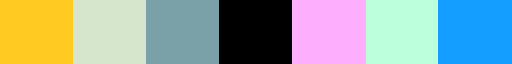

In [37]:
p.legend_dict[attributes[0]]['cmap']

In [39]:
p.legend_dict[attributes[2]]['values']

['vs', 'inconnu', 'vi', 'vr']

## Display one object (attribute = 'lithology')

In [40]:
bh = 6
p.boreholes_3d[bh].components

{0: [Component({'lithology': 'sable'}),
  Component({'arsenic': 'vi'}),
  Component({'cadmium': 'vs'})],
 1: [Component({'lithology': 'argile'}),
  Component({'arsenic': 'vr'}),
  Component({'cadmium': 'vs'})],
 2: [Component({'lithology': 'marne'}),
  Component({'arsenic': 'vs'}),
  Component({'cadmium': 'vr'})],
 3: [Component({'lithology': 'charbon'}),
  Component({'arsenic': 'vi'}),
  Component({'cadmium': 'inconnu'})],
 4: [Component({'lithology': 'dolomie'}),
  Component({'arsenic': 'vi'}),
  Component({'cadmium': 'vi'})],
 5: [Component({'lithology': 'calcaire'}),
  Component({'arsenic': 'vs'}),
  Component({'cadmium': 'vr'})]}

/home/yanathan/Projects/GSDMA/utils/visual.py:425: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect = mpl.patches.Rectangle(origin, w, thick, fc=fc, lw=lw, hatch=d.hatch,
/home/yanathan/Projects/GSDMA/utils/visual.py:425: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'=". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect = mpl.patches.Rectangle(origin, w, thick, fc=fc, lw=lw, hatch=d.hatch,
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/legend.py:311: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'=". Passing invalid values is deprecated since 3

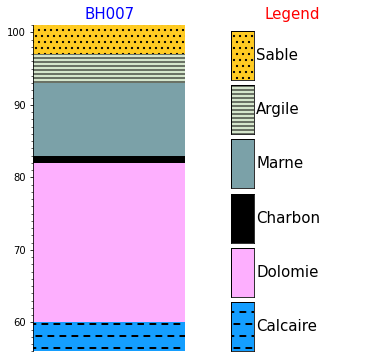

In [41]:
p.boreholes_3d[bh].log_plot()

In [42]:
sargs = dict(title='Test_legend', title_font_size=30, label_font_size=12, n_labels=0,
             fmt="%.2f", font_family="arial", color='k',interactive=True, 
             vertical=True, italic=True, shadow=False,)

In [43]:
p.boreholes_3d[bh].plot3d(custom_legend=False, scalar_bar_args=sargs)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## Plot with another attribute

/home/yanathan/Projects/GSDMA/utils/visual.py:425: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect = mpl.patches.Rectangle(origin, w, thick, fc=fc, lw=lw, hatch=d.hatch,
/home/yanathan/Projects/GSDMA/utils/visual.py:425: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'=". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect = mpl.patches.Rectangle(origin, w, thick, fc=fc, lw=lw, hatch=d.hatch,
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/legend.py:311: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'=". Passing invalid values is deprecated since 3

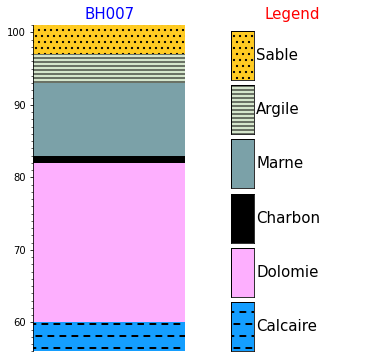

In [44]:
at = 0
p.boreholes_3d[bh].log_plot(repr_attribute=attributes[at])

In [45]:
p.boreholes_3d[bh].plot3d(repr_attribute=attributes[at])

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [46]:
p.boreholes_orm[0].intervals_values

2021-08-03 15:07:02,736 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-08-03 15:07:02,738 INFO sqlalchemy.engine.Engine [cached since 2.562s ago] ('BH001',)


{0: '{"lithology": "sable"}, {"arsenic": "vs"}, {"cadmium": "vs"}', 1: '{"lithology": "argile"}, {"arsenic": "inconnu"}, {"cadmium": "inconnu"}', 2: '{"lithology": "marne"}, {"arsenic": "vi"}, {"cadmium": "inconnu"}', 3: '{"lithology": "charbon"}, {"arsenic": "vr"}, {"cadmium": "inconnu"}'}

In [47]:
p.boreholes_3d[bh].intervals[0]

Interval({'top': Position({'middle': 101.0, 'x': 152794.0, 'y': 121111.0, 'units': 'm'}), 'base': Position({'middle': 97.0, 'x': 152794.0, 'y': 121111.0, 'units': 'm'}), 'description': '{"lithology": "sable"}, {"arsenic": "vi"}, {"cadmium": "vs"}', 'data': {}, 'components': [Component({'lithology': 'sable'}), Component({'arsenic': 'vi'}), Component({'cadmium': 'vs'})]})

### Display project boreholes

In [48]:
bh3d_vtk = p.boreholes_3d[bh]._vtk
bh3d_vtk

PolyData (0x7f13870ed0a0)
  N Cells:	312
  N Points:	1200
  X Bounds:	1.528e+05, 1.528e+05
  Y Bounds:	1.211e+05, 1.211e+05
  Z Bounds:	5.600e+01, 1.010e+02
  N Arrays:	6

In [ ]:
at = 1
p.plot3d(repr_attribute=attributes[at],  bg_color=["royalblue", "aliceblue"], 
                      window_size=(800, 500))

### Boreholes in 3D using X3D for interaction within the notebook

In [ ]:
type(p.boreholes_3d[0].omf_legend)